In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
import random

In [2]:
def neighbor_edges_of_node(graph, node):
    neighbor_edges = []
    for edge in graph.edges():
        if node in edge:
            neighbor_edges.append(edge)
    return neighbor_edges

In [3]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [4]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph

In [5]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [6]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):

    print(coloring_result)
    with open('./results/ga_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        if coloring_result == -1:
            result_file.write("Time limit exceeded.\n")
            print("Time limit exceeded.\n")
        else:
            if coloring_result:
                result_file.write("Minimum edge coloring found.\n")
                result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
                result_file.write(f"Number of iterations: {iter}\n")

                print("Minimum edge coloring found.")
                print("Number of colors:", len(set(coloring_result)))  
                print("Number of iterations:", iter)
                draw_colored_graph(graph, coloring_result)
                plt.close() 
            else:
                result_file.write("No solution found.\n")
                print("No solution found.\n") 

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [7]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts = [int(part) if part.isdigit() else part for part in parts]
    return parts

In [8]:
def is_feasible(solution):
    return any(solution)

In [9]:
class Individual:
    def __init__(self, graph):
        self.graph = graph  
        self.num_of_edges = len(graph.edges())
        self.coloring = [random.randrange(1, len(graph.edges())) for _ in range(len(graph.edges()))]
        self.fitness = self.calc_fitness()  

    
    def calc_fitness(self):
        graph = self.graph
        edge_color = {edge: self.coloring[i] for i, edge in enumerate(graph.edges())}
        num = 0
    
        for edge in graph.edges():
            indicator = True
    
            u, v = edge
            
            u_edges = neighbor_edges_of_node(graph, u)
            v_edges = neighbor_edges_of_node(graph, v)
    
            u_edges.remove(edge)
            v_edges.remove(edge)
            
            for i in range(len(u_edges)):
                if edge_color[u_edges[i]] == edge_color[edge]:
                    indicator = False
            
            for j in range(len(v_edges)):  
                if edge_color[v_edges[j]] == edge_color[edge]:
                    indicator = False
    
            if indicator:
                num += 1

        return num


In [10]:
def selection(population, tournament_size):
    chosen = random.sample(population, tournament_size)
    return max(chosen, key=lambda x: x.fitness)

In [11]:
def crossover(parent1, parent2, child1, child2):
    random_pos = random.randrange(0, len(parent1.coloring))
    
    child1.coloring[:random_pos] = parent1.coloring[:random_pos]
    child1.coloring[random_pos:] = parent2.coloring[random_pos:]
    
    child2.coloring[:random_pos] = parent2.coloring[:random_pos]
    child2.coloring[random_pos:] = parent1.coloring[random_pos:]

In [12]:
def mutation(individual, mutation_prob):
    for i in range(len(individual.coloring)):
        if random.random() < mutation_prob:
            new_color = random.randrange(1, individual.num_of_edges)
            while new_color == individual.coloring[i]:
                new_color = random.randrange(1, individual.num_of_edges)
            individual.coloring[i] = new_color

In [13]:
def genetic_algorithm(graph, population_size, num_generations, tournament_size, elitism_size, mutation_prob):

    population = [Individual(graph) for _ in range(population_size)]
    new_population = population.copy()

    for i in range(num_generations):
        population.sort(key=lambda x: x.fitness, reverse=True)
        new_population[:elitism_size] = population[:elitism_size]
        
        for j in range(elitism_size, population_size, 2):
            parent1 = selection(population, tournament_size)
            parent2 = selection(population, tournament_size) 
            
            crossover(parent1, parent2, child1=new_population[j], child2=new_population[j+1])

            mutation(new_population[j], mutation_prob)
            mutation(new_population[j+1], mutation_prob)
            
            new_population[j].fitness = new_population[j].calc_fitness()
            new_population[j+1].fitness = new_population[j+1].calc_fitness()
        
        population = new_population.copy()
        
        best_individual = max(population, key=lambda x: x.fitness)

        idx = population.index(best_individual)

    if is_valid_coloring(graph, best_individual.coloring):
        idx = population.index(best_individual)
        return best_individual, idx
    else:
        return -100, -100


In [14]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")

            start_time = time.time()
            graph = read_graph_from_file(filepath)
            best_individual, index = genetic_algorithm(graph, 
                                                population_size=100,
                                                num_generations=10,
                                                tournament_size=7,
                                                elitism_size=10,
                                                mutation_prob=0.05)
            end_time = time.time()

            if best_individual == -100:
                write_output(graph, file, None, index, start_time, end_time)
            else:
                write_output(graph, file, best_individual.coloring, index, start_time, end_time)     

Running test graph_101_edges.txt...


[59, 21, 4, 82, 69, 99, 65, 17, 55, 33, 36, 53, 16, 26, 65, 29, 42, 88, 41, 93, 86, 64, 40, 2, 48, 67, 71, 61, 37, 78, 97, 92, 75, 93, 11, 52, 98, 83, 94, 13, 43, 26, 56, 98, 43, 60, 62, 91, 38, 88, 44, 31, 48, 26, 68, 8, 27, 45, 91, 21, 17, 19, 63, 92, 99, 53, 45, 6, 15, 83, 58, 21, 42, 54, 72, 9, 45, 91, 52, 90, 2, 20, 25, 88, 44, 51, 16, 41, 66, 70, 37, 33, 20, 62, 62, 53, 12, 76, 73, 80, 14]
Minimum edge coloring found.
Number of colors: 69
Number of iterations: 4


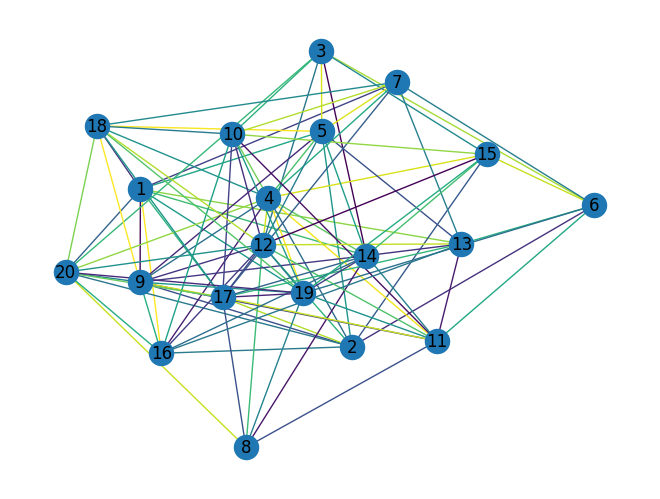

Time taken: 24.30883240699768 seconds

Running test graph_121_edges.txt...
[111, 17, 53, 63, 54, 47, 71, 12, 91, 13, 118, 34, 57, 5, 91, 30, 7, 94, 53, 74, 84, 32, 28, 19, 40, 1, 63, 37, 71, 106, 21, 80, 33, 81, 102, 14, 97, 93, 62, 93, 44, 17, 40, 117, 11, 29, 21, 103, 30, 22, 80, 20, 106, 95, 62, 119, 97, 52, 25, 44, 72, 102, 45, 79, 49, 67, 56, 109, 7, 42, 74, 75, 43, 59, 34, 46, 114, 49, 4, 61, 18, 39, 63, 68, 83, 120, 109, 68, 69, 46, 63, 62, 86, 66, 1, 42, 2, 14, 76, 105, 59, 65, 87, 83, 23, 65, 68, 57, 26, 120, 89, 110, 33, 60, 109, 104, 111, 64, 76, 109, 27]
Minimum edge coloring found.
Number of colors: 82
Number of iterations: 0


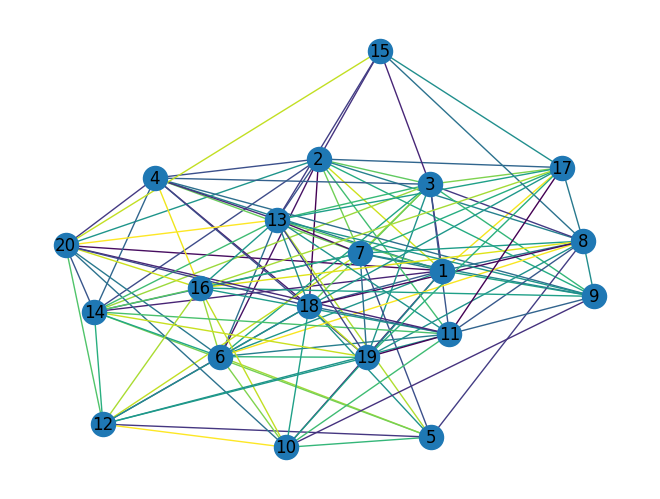

Time taken: 28.910260438919067 seconds

Running test graph_140_edges.txt...
[52, 84, 33, 127, 26, 51, 123, 14, 124, 44, 103, 85, 95, 122, 112, 100, 78, 107, 59, 105, 35, 102, 125, 131, 8, 7, 108, 99, 87, 108, 1, 66, 38, 104, 34, 123, 88, 6, 93, 69, 118, 21, 121, 103, 110, 70, 18, 84, 15, 10, 52, 89, 57, 14, 106, 16, 19, 40, 46, 80, 82, 1, 27, 69, 10, 98, 14, 124, 13, 45, 5, 31, 29, 8, 127, 32, 124, 128, 101, 135, 68, 93, 46, 115, 111, 131, 9, 101, 50, 86, 99, 32, 15, 68, 95, 109, 62, 49, 125, 105, 54, 47, 25, 138, 83, 26, 92, 113, 9, 56, 38, 109, 56, 23, 47, 29, 31, 132, 110, 96, 61, 128, 102, 112, 34, 20, 124, 55, 73, 10, 126, 62, 115, 83, 1, 118, 71, 1, 113, 133]
Minimum edge coloring found.
Number of colors: 93
Number of iterations: 4


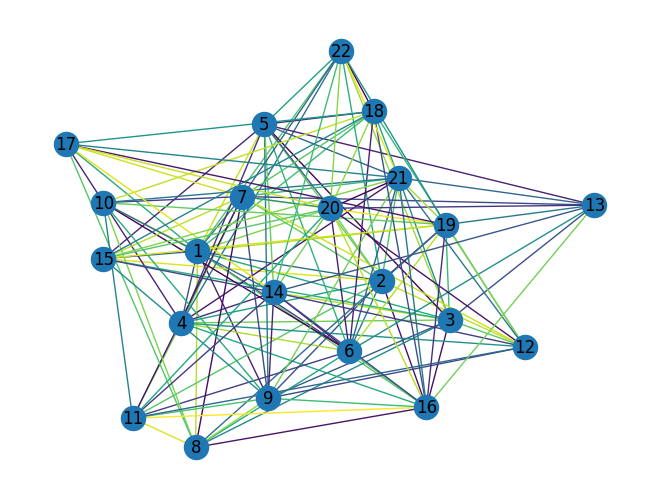

Time taken: 34.24151039123535 seconds

Running test graph_156_edges.txt...
[116, 57, 126, 151, 37, 54, 89, 3, 107, 119, 83, 67, 143, 148, 65, 21, 111, 33, 121, 152, 28, 129, 113, 9, 83, 59, 133, 30, 40, 90, 34, 11, 44, 97, 87, 118, 84, 149, 85, 71, 91, 74, 48, 58, 104, 35, 85, 124, 56, 1, 135, 37, 45, 148, 14, 83, 152, 129, 92, 137, 33, 40, 135, 136, 91, 141, 102, 153, 109, 77, 14, 8, 62, 95, 141, 71, 51, 105, 17, 39, 28, 86, 113, 82, 16, 93, 78, 108, 124, 71, 98, 25, 78, 137, 72, 18, 51, 97, 7, 115, 31, 97, 36, 91, 124, 131, 125, 48, 149, 67, 132, 6, 87, 139, 50, 45, 51, 88, 52, 15, 95, 99, 23, 7, 134, 131, 146, 101, 80, 82, 5, 55, 3, 75, 24, 149, 31, 35, 10, 151, 18, 24, 68, 104, 19, 69, 39, 83, 91, 107, 140, 70, 119, 72, 64, 82]
Minimum edge coloring found.
Number of colors: 106
Number of iterations: 6


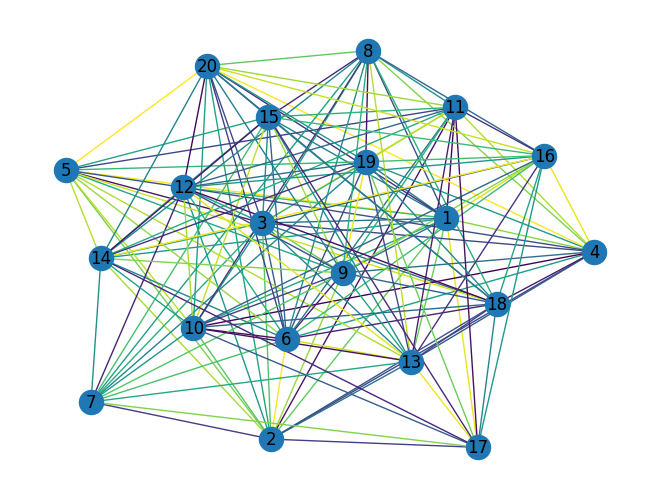

Time taken: 34.57950782775879 seconds

Running test graph_165_edges.txt...
[85, 115, 16, 51, 156, 98, 6, 153, 134, 135, 129, 13, 27, 67, 96, 124, 49, 119, 45, 3, 34, 75, 6, 162, 76, 36, 67, 159, 119, 97, 60, 103, 104, 100, 29, 157, 82, 10, 2, 78, 163, 32, 3, 152, 111, 82, 121, 108, 162, 56, 46, 19, 119, 140, 128, 72, 120, 1, 103, 17, 87, 30, 3, 119, 97, 145, 63, 58, 74, 136, 36, 88, 118, 159, 6, 25, 2, 96, 15, 140, 35, 65, 113, 66, 157, 2, 20, 38, 125, 90, 29, 79, 69, 104, 158, 17, 28, 80, 161, 31, 15, 92, 56, 12, 108, 16, 133, 156, 151, 115, 25, 22, 1, 136, 3, 110, 51, 131, 33, 21, 68, 8, 116, 114, 98, 70, 34, 24, 83, 130, 111, 103, 99, 101, 79, 137, 156, 69, 53, 51, 158, 47, 134, 70, 109, 79, 45, 124, 7, 79, 118, 153, 100, 159, 136, 7, 80, 53, 114, 43, 96, 51, 24, 132, 99]
Minimum edge coloring found.
Number of colors: 104
Number of iterations: 50


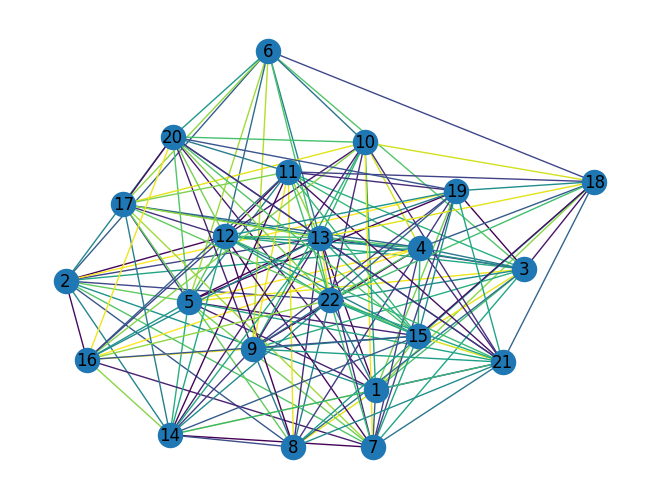

Time taken: 36.157265186309814 seconds

Running test graph_177_edges.txt...
[29, 92, 90, 75, 150, 82, 164, 117, 34, 63, 95, 171, 26, 160, 112, 62, 108, 174, 24, 5, 49, 139, 21, 25, 78, 14, 135, 172, 120, 132, 16, 163, 140, 148, 128, 28, 58, 35, 86, 12, 68, 163, 5, 46, 15, 74, 133, 148, 10, 17, 118, 49, 101, 99, 93, 154, 139, 155, 52, 127, 163, 123, 7, 48, 83, 59, 85, 158, 27, 115, 152, 53, 82, 2, 144, 25, 126, 149, 66, 142, 60, 48, 133, 5, 110, 115, 91, 68, 10, 18, 90, 138, 17, 23, 74, 50, 106, 67, 80, 66, 23, 159, 131, 78, 12, 140, 145, 127, 70, 89, 125, 144, 14, 7, 91, 71, 81, 3, 166, 33, 87, 104, 70, 39, 49, 62, 116, 14, 38, 47, 2, 174, 98, 77, 50, 7, 18, 142, 121, 148, 51, 101, 58, 10, 106, 16, 139, 73, 68, 109, 22, 15, 100, 111, 167, 97, 33, 12, 172, 119, 55, 121, 13, 31, 112, 91, 61, 72, 37, 167, 145, 155, 114, 29, 106, 156, 53]
Minimum edge coloring found.
Number of colors: 119
Number of iterations: 3


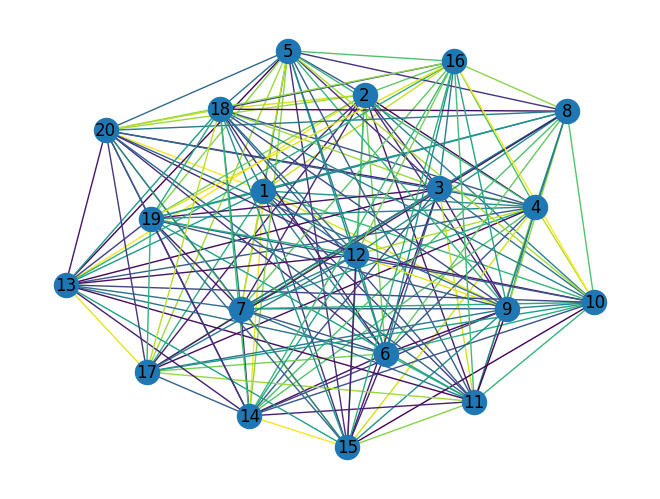

Time taken: 47.48668956756592 seconds

Running test graph_204_edges.txt...
None
No solution found.

Time taken: 66.98116183280945 seconds

Running test graph_227_edges.txt...
[35, 51, 209, 169, 159, 32, 217, 200, 185, 38, 158, 47, 117, 103, 167, 157, 21, 107, 33, 152, 8, 145, 141, 62, 114, 189, 80, 32, 73, 76, 31, 130, 147, 88, 118, 173, 21, 106, 68, 215, 17, 194, 82, 148, 151, 165, 138, 216, 4, 154, 135, 162, 15, 158, 173, 84, 153, 23, 57, 88, 177, 222, 200, 147, 13, 82, 204, 90, 215, 42, 163, 106, 6, 33, 14, 93, 219, 39, 142, 104, 195, 108, 3, 53, 133, 94, 175, 99, 109, 111, 5, 72, 56, 162, 85, 59, 186, 79, 170, 40, 152, 205, 28, 138, 197, 25, 208, 146, 183, 150, 126, 123, 41, 214, 66, 44, 142, 197, 43, 176, 10, 64, 28, 56, 107, 11, 157, 177, 173, 58, 102, 181, 118, 138, 95, 42, 64, 225, 72, 154, 148, 75, 60, 63, 189, 206, 172, 37, 19, 160, 122, 49, 203, 209, 64, 129, 78, 23, 70, 32, 34, 140, 120, 203, 97, 205, 94, 87, 120, 126, 96, 173, 23, 117, 5, 154, 172, 35, 148, 30, 58, 221, 11

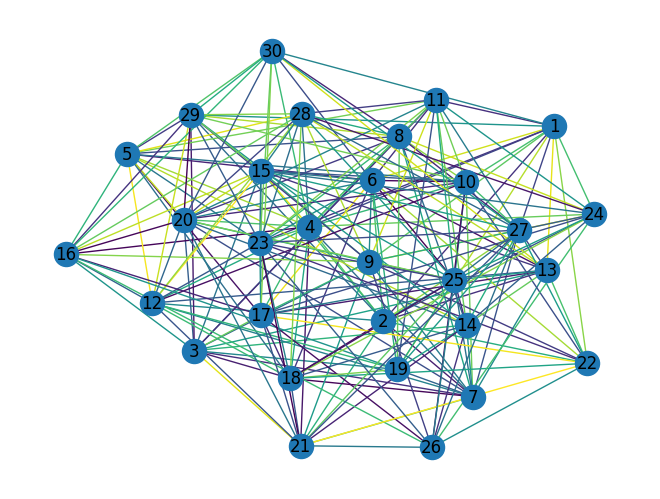

Time taken: 65.29593420028687 seconds

Running test graph_273_edges.txt...
[81, 90, 265, 216, 234, 92, 151, 178, 158, 142, 256, 209, 73, 170, 95, 46, 103, 18, 264, 166, 203, 85, 227, 25, 20, 94, 233, 53, 61, 215, 59, 224, 23, 205, 97, 80, 41, 82, 164, 57, 31, 225, 204, 199, 251, 236, 97, 28, 1, 169, 71, 156, 188, 145, 208, 52, 51, 204, 68, 223, 213, 240, 195, 136, 246, 251, 52, 252, 204, 244, 101, 8, 34, 248, 55, 120, 158, 124, 257, 176, 97, 121, 68, 28, 75, 144, 18, 127, 139, 10, 224, 152, 209, 171, 257, 71, 206, 213, 46, 132, 232, 209, 114, 55, 125, 35, 245, 174, 122, 194, 67, 16, 165, 220, 48, 89, 248, 7, 218, 267, 38, 3, 181, 94, 160, 111, 62, 27, 39, 237, 197, 229, 153, 109, 33, 30, 148, 89, 121, 266, 214, 159, 158, 150, 74, 15, 100, 253, 259, 122, 202, 249, 107, 17, 21, 78, 13, 237, 44, 3, 239, 180, 125, 263, 238, 43, 83, 263, 195, 247, 43, 108, 20, 193, 15, 228, 266, 71, 112, 237, 31, 146, 131, 194, 102, 15, 57, 234, 208, 244, 22, 153, 213, 16, 180, 217, 199, 95, 235, 245, 194, 

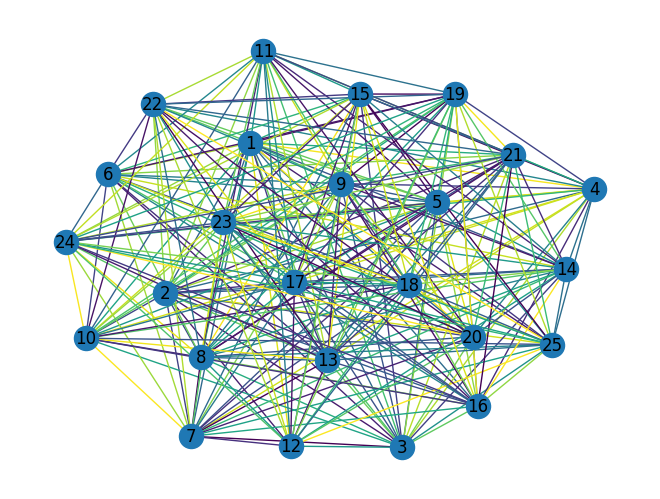

Time taken: 102.20430755615234 seconds

Running test graph_275_edges.txt...
[66, 259, 212, 46, 190, 74, 231, 16, 265, 269, 192, 243, 63, 162, 266, 223, 245, 59, 175, 255, 57, 177, 12, 238, 63, 192, 65, 43, 243, 216, 42, 112, 221, 67, 99, 9, 193, 250, 167, 218, 271, 25, 122, 243, 235, 144, 146, 151, 164, 245, 153, 124, 32, 27, 63, 198, 142, 234, 27, 158, 99, 11, 65, 229, 151, 251, 242, 222, 126, 113, 115, 78, 223, 88, 115, 23, 29, 4, 21, 209, 41, 130, 222, 110, 51, 53, 223, 139, 7, 147, 166, 268, 118, 151, 164, 83, 36, 132, 100, 197, 242, 274, 124, 91, 227, 196, 138, 82, 266, 67, 160, 21, 180, 231, 9, 10, 96, 241, 55, 218, 123, 98, 120, 233, 128, 66, 253, 191, 154, 243, 38, 216, 52, 77, 138, 26, 20, 106, 193, 165, 228, 217, 8, 262, 255, 218, 69, 206, 190, 203, 22, 216, 132, 208, 156, 210, 95, 179, 202, 153, 191, 244, 146, 112, 215, 122, 172, 192, 170, 263, 189, 151, 43, 184, 268, 115, 274, 59, 75, 123, 244, 107, 36, 189, 66, 211, 134, 75, 180, 16, 193, 113, 163, 162, 131, 105, 160, 235,

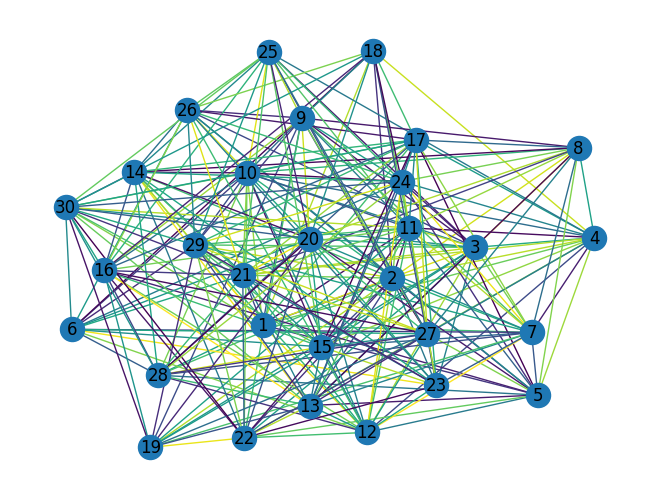

Time taken: 96.86642646789551 seconds



In [15]:
with open('./results/ga_results.txt', 'w') as result_file:
    result_file.write("")

run_tests('./tests')